### Optimal control of phenomenological models, e.g. the model model
This notebook shows how to compute the optimal control (OC) signal for the FHN model for a simple example task. For the Hopf-model the OC can be computed completely analogously.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.fhn import FHNModel
from neurolib.models.hopf import HopfModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_fhn
from neurolib.optimal_control import oc_hopf
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 3

We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [22]:
# We import the model
model = FHNModel()
# model = HopfModel()    # OC can be computed for the Hopf model completely analogously

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 100.
amplitude = 1.
period = duration

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
# input[0,1:-2] = np.sin(2.*np.pi*np.arange(0,duration-0.2, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
if model.name == 'fhn':
    x_init, y_init = 0., 0.
elif model.name == 'hopf':
    x_init, y_init = -1.0507332990914269,  -0.2315292520774167
    model.params.x_ou_mean = -1

model.params["xs_init"] = np.array([[x_init]])
model.params["ys_init"] = np.array([[y_init]])

0.0


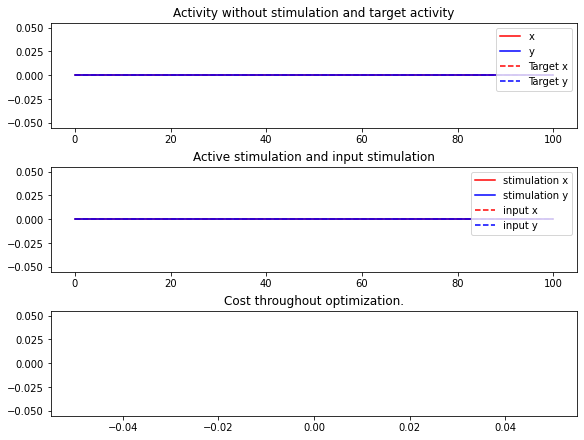

In [23]:
# We set the stimulus in x and y variables, and run the simulation
model.params["x_ext"] = input.copy()
model.params["y_ext"] = zero_input.copy()
model.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
model.params["x_ext"] = zero_input
model.params["y_ext"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)
print(state[0,1,-1])

plot_oc_singlenode(duration, dt, state, target, control, target_input)

Compute control for a deterministic system
Cost in iteration 0: 0.0
Cost in iteration 1: 0.0
Cost in iteration 2: 0.0
Cost in iteration 3: 0.0
Cost in iteration 4: 0.0
Cost in iteration 5: 0.0
Final cost : 0.0


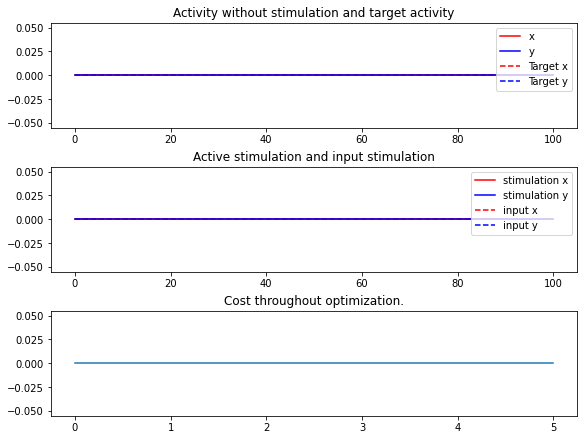

In [24]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model.params["x_ext"] = zero_input.copy()
model.params["y_ext"] = zero_input.copy()

if model.name == 'fhn':
    model_controlled = oc_fhn.OcFhn(model, target, w_p=1, w_2=0, print_array=[1,2,3,4,5,100,200,300,400,500])
elif model.name == 'hopf':
    model_controlled = oc_hopf.OcHopf(model, target, w_p=1, w_2=0, print_array=[1,2,3,4,5,100,200,300,400,500])

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(5)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

Compute control for a deterministic system
Cost in iteration 0: 0.0
Cost in iteration 1: 0.0
Final cost : 0.0


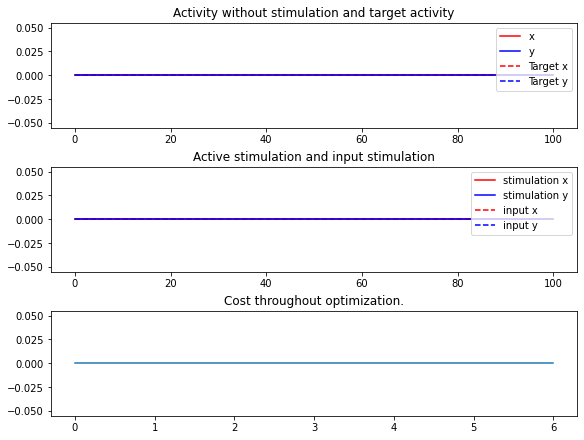

In [25]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(1)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

### Network case

Let us know study a simple 2-node network of FHN oscillators. We first need to define the coupling matrix and the delay matrix. We can then initialize the model.

xs init 0.9283288957027521
xs init 0.9283288957027521


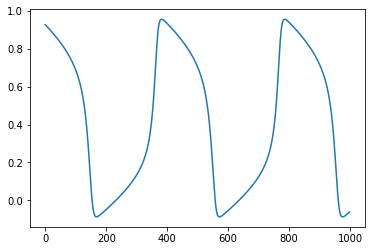

0.9266475809376016 -0.06106243924183048
xs init 0.9283288957027521
-0.10774873916022733
-0.06106243924183048
0.9599616815255932
0.8606354191760924


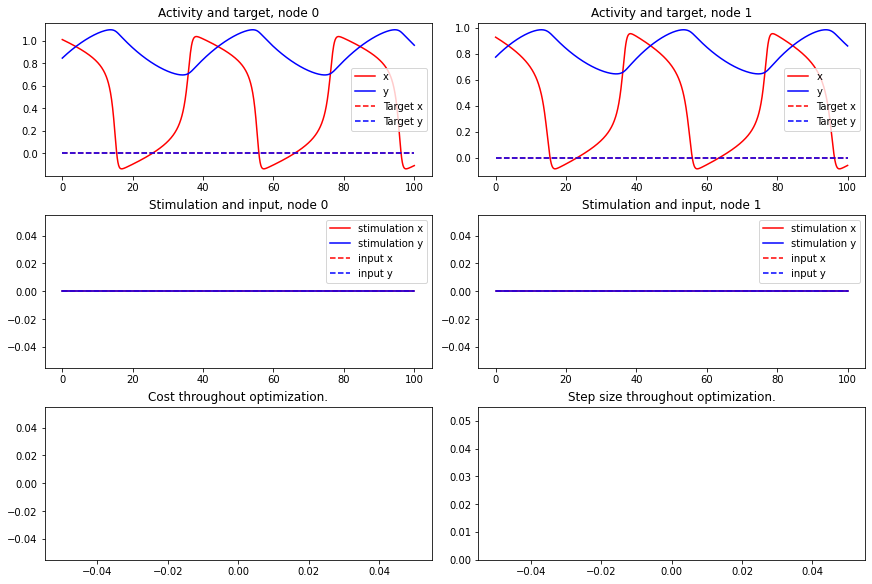

In [30]:
cmat = np.array( [[0., 1.], [0.5, 0.]] )  # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

if model.name == 'fhn':
    model = FHNModel(Cmat=cmat, Dmat=dmat)
elif model.name == 'hopf':
    model = HopfModel(Cmat=cmat, Dmat=dmat)    

model.params.coupling = "additive" # use additive coupling

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in y-channel in node 0

# if control_mat[0,0] == 0. and control_mat[1,0] == 0:
    # if x is input channel, high connection strength can lead to numerical issues
    # model.params.K_gl = 5. # increase for stronger connectivity, WARNING: too high value will cause numerical problems

model.params["duration"] = duration
model.params["x_ou_mean"] = 0.8

if model.name == 'fhn':
    model.params["xs_init"] = np.vstack( [1.0102162724854475, 0.9283288957027521] )
    model.params["ys_init"] = np.vstack( [0.8458881386715335, 0.7744765218690157] )
elif model.name == 'hopf':
    model.params["xs_init"] = np.vstack( [-1.24477372363938, -1.1636461406585998] )
    model.params["ys_init"] = np.vstack( [-0.18658424114911804, -0.20319311996665057] )
    print('xs init', model.params["xs_init"][1,0])
    model.params.x_ou_mean = -1.

# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["x_ext"] = input_nw[:,0,:]
model.params["y_ext"] = input_nw[:,1,:]

print('xs init', model.params["xs_init"][1,0])

model.run()

print('xs init', model.params["xs_init"][1,0])

# Define the result of the stimulation as target
target = np.concatenate( (np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)
target = np.zeros((target.shape))

# Remove stimuli and re-run the simulation
model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.concatenate( (model.params["xs_init"], model.params["ys_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.x, model.y), axis=1)), axis=2)

plt.plot(model.x[1,:])
plt.show()
print(model.x[1,0], model.x[1,-1])
print('xs init', model.params["xs_init"][1,0])

print(state[0,0,-1])
print(state[1,0,-1])
print(state[0,1,-1])
print(state[1,1,-1])

plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

In [45]:
prec_mat = np.zeros( (model.params.N, len(model.output_vars)) )
prec_mat[1,0] = 1. # only measure in y-channel in node 1

model.params["x_ext"] = zero_input_nw[:,0,:]
model.params["y_ext"] = zero_input_nw[:,0,:]

if model.name == 'fhn':
    model_controlled = oc_fhn.OcFhn(model, target, w_p=1, w_2=0.001, print_array=[1,2,10,50,100,200,300,400,500], control_matrix=control_mat, precision_matrix=prec_mat, precision_cost_interval=[900,-1])
elif model.name == 'hopf':
    model_controlled = oc_hopf.OcHopf(model, target, w_p=1, w_2=0, print_array=[1,2,10,50,100,200,300,400,500], control_matrix=control_mat, precision_matrix=prec_mat)

model_controlled.step = 10.
model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control

#plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 8.921535233873819
Cost in iteration 1: 6.625313428872359
Cost in iteration 2: 6.493135402797062
Cost in iteration 10: 5.5188650805806025
Cost in iteration 50: 2.3835704394871104
Cost in iteration 100: 0.867786048155008
Final cost : 0.867786048155008


Compute control for a deterministic system
Cost in iteration 0: 0.009923062348468592
Cost in iteration 1: 0.009921533713191783
Cost in iteration 2: 0.009918554931109682
Cost in iteration 10: 0.009900038407474464
Cost in iteration 50: 0.00981119206621806
Cost in iteration 100: 0.009707221023284696
Cost in iteration 200: 0.009522266019928432
Cost in iteration 300: 0.009358937721755894
Cost in iteration 400: 0.009093532543816302
Cost in iteration 500: 0.008844929583638373
Final cost : 0.008208112709020396


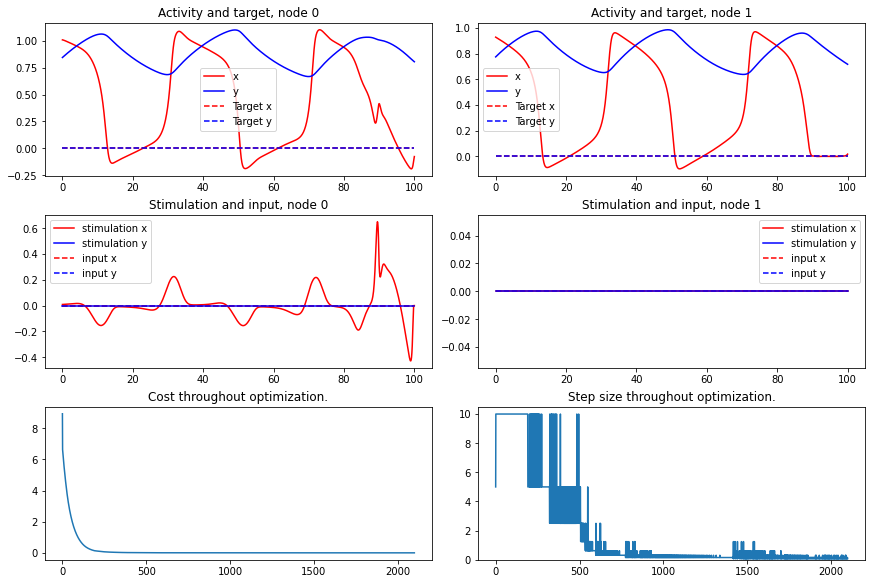

[0.0086368  0.00877844 0.00892607 0.00907924]


In [47]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
# model_controlled.step = 100.
model_controlled.optimize(1000)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)
print(control[0,0,:4])

[0. 0. 0. 0.]


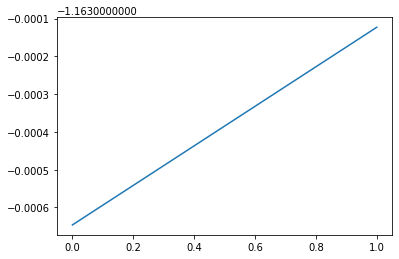

In [9]:
print(model_controlled.model.params["x_ext"][0,:4])

plt.plot(state[1,0,:2])
#plt.plot(target[1,0,:2], linestyle=':')
plt.show()

In [10]:
model_controlled.model.run()
print(model_controlled.model.x[1,:5])

[-1.16321854 -1.16295137 -1.16278699 -1.16268839 -1.16263183]


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.fhn import FHNModel
from neurolib.models.hopf import HopfModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_fhn
from neurolib.optimal_control import oc_hopf
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 3

model = HopfModel()
duration = 100.
dt = model.params["dt"]
amplitude = 1.
period = duration

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-2] = np.sin(2.*np.pi*np.arange(0,duration-0.2, dt)/period) # other functions or random values can be used as well

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
